In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
mido.Message(type='note_on').type

'note_on'

In [6]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data

Encoding midi-data
 500
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/05 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/03 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/04 8th Perc.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/06 8th Perc.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/02 8th Hat.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/07 8th Perc.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/01 8th Hat.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/05 Straight Line 136BPM/06 8th hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/05 Straight Line 136BPM/02 8th Ride.mid"),
 (9,
  "../datasets/dr

In [8]:
x_train.shape

(500, 160, 7, 1)

In [9]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((500, 160, 7, 1), 450)

In [10]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 7)


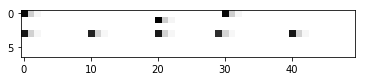

m (50, 7)


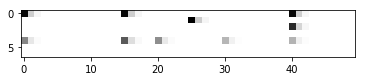

array(["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/05 8th Hat.mid",
       '../datasets/drum_midi//50´s Drummer MIDI Files/06 Soul - Funk/10 Syncopated Ride 128BPM/03 16th Cym.mid'],
      dtype='<U106')

In [11]:
i = 0
j = 399
plot.single(x_train[i, :50,:,0])
plot.single(x_train[j, :50,:,0])
# plot.single(x_train[2, :50,:,0])
np.array(labels)[[i,j]]

In [12]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 7, 1)

In [13]:
latent_dim = 5
epsilon_std = 1.0

In [14]:
def encoder(input_shape, dropout=0.1):
    encoder_input = Input(shape=input_shape)
    nodes = np.prod(input_shape)
    timesteps, notes, channels = input_shape
    
    # Convolution
    h = encoder_input
    k = (2,1)
    s = (2,1)
    
    h = Reshape((timesteps, notes))(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    
    h = Bidirectional(LSTM(128))(h)

    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # no activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # no activation='relu'
    
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [15]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 7, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 160, 7)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 159, 64)      960         reshape_1[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 256)          197632      conv1d_1[0][0]                   
__________________________________________________________________________________________________
z_mean (De

In [17]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim,epsilon_std)

In [18]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [19]:
def list_decoders(output_shape):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape

    # keras.examples.variational_autoencoder_deconv.py
    decoders = []
    decoders += [ Dense(256) ]
    decoders += [ LeakyReLU(alpha=0.3) ]
    
    # add a bypass layer
    w = 256
    decoders += [ Dense(w, activation='relu') ]
    extra_decoders = []
    for _ in range(3):
        extra_decoders += [ Dense(w, activation='elu', bias_initializer='zeros') ]

    extra_d = Lambda(lambda layer: utils.composition(extra_decoders, layer))
    decoders += [ Lambda(lambda layer: Add()([layer, extra_d(layer)])) ]
    
    decoders += [ BatchNormalization(momentum=0.9) ]
    n = 10 # 5

    decoders += [ RepeatVector(n) ]
    decoders += [ Bidirectional(LSTM(128, return_sequences=True)) ]
    
    # Embedding decoder
    
    embedding_len = int(timesteps / n)
    filters = 250
    decoders += [ TimeDistributed(Dense(filters, activation='relu')) ]
    decoders += [ TimeDistributed(Dense(notes * embedding_len, activation='sigmoid')) ]
    decoders += [ Reshape((timesteps, notes, 1)) ]

    return decoders

In [20]:
decoders = list_decoders(input_shape)

In [21]:
decoded = utils.composition(decoders, z_output, verbose=False)
# layer1, = layers

In [22]:
# decoded = utils.composition(decoders, z_mean, verbose=False)

In [23]:
# layer1.output

In [24]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 7, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 5), (None, 5 201162      input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 5)            0           encoder_model-[2][0]             
                                                                 encoder_model-[2][1]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          1536        lambda_2[0][0]                   
__________

In [25]:
# vae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [26]:
# Compute VAE loss
def vae_loss(beta=1.):
#     beta = ((1.0 - tf.pow(hparams.beta_rate, tf.to_float(self.global_step)))
#             * hparams.max_beta)
#     self.loss = tf.reduce_mean(r_loss) + beta * tf.reduce_mean(kl_cost)
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss = max(kl_loss, free_bits)
    mse = K.mean(keras.losses.mean_absolute_error(vae_input, vae_output))
    vae_loss = K.mean(xent_loss + beta * kl_loss + 0.2 * mse)
    return vae_loss

vae_loss = vae_loss(beta=0.5)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Output "reshape_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_2" during training.
  app.launch_new_instance()


In [27]:
K.int_shape(z_mean)

(None, 5)

In [28]:
batch_size = 50
epochs = 500
params = {'batch_size': batch_size, 'return_y': False}

In [29]:
phase_mod = 0.01
whitening = False

In [30]:
m = 250
useDataGenerator = False
# useDataGenerator = True

x = x_train[:m]
# x = x_train
# i = [0,1, 7,8, 14,15, 399,400]
# x = x_train[i]
# x = np.concatenate([x for _ in range(10)])
print('x:', x.shape)

print('batch_size: %i' % batch_size)
print('update-iterations:', round(epochs * x.shape[0] / batch_size))
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
            # x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x, epochs=epochs, validation_data=(x_test, None))
    history = h.history

x: (250, 160, 7, 1)
batch_size: 50
update-iterations: 2500
Train on 250 samples, validate on 50 samples
Epoch 1/500
250/250 [==============================] - 8s 30ms/step - loss: 650.7954 - val_loss: 448.4488
Epoch 2/500
250/250 [==============================] - 5s 20ms/step - loss: 293.1964 - val_loss: 170.1065
Epoch 3/500
250/250 [==============================] - 5s 19ms/step - loss: 145.2025 - val_loss: 190.1497
Epoch 4/500
250/250 [==============================] - 5s 20ms/step - loss: 141.0712 - val_loss: 159.2189
Epoch 5/500
250/250 [==============================] - 7s 26ms/step - loss: 124.0949 - val_loss: 147.8748
Epoch 6/500
250/250 [==============================] - 6s 23ms/step - loss: 121.3183 - val_loss: 145.0114
Epoch 7/500
250/250 [==============================] - 5s 20ms/step - loss: 119.1053 - val_loss: 145.4189
Epoch 8/500
250/250 [==============================] - 5s 20ms/step - loss: 117.9118 - val_loss: 143.5301
Epoch 9/500
250/250 [===========================

250/250 [==============================] - 9s 35ms/step - loss: 90.5988 - val_loss: 124.9688
Epoch 77/500
250/250 [==============================] - 8s 34ms/step - loss: 90.0073 - val_loss: 122.4142
Epoch 78/500
250/250 [==============================] - 8s 32ms/step - loss: 88.7202 - val_loss: 121.5226
Epoch 79/500
250/250 [==============================] - 8s 31ms/step - loss: 87.9071 - val_loss: 121.3866
Epoch 80/500
250/250 [==============================] - 8s 33ms/step - loss: 87.1867 - val_loss: 122.6421
Epoch 81/500
250/250 [==============================] - 8s 33ms/step - loss: 86.7128 - val_loss: 122.3987
Epoch 82/500
250/250 [==============================] - 8s 33ms/step - loss: 85.6691 - val_loss: 120.9864
Epoch 83/500
250/250 [==============================] - 8s 33ms/step - loss: 85.1797 - val_loss: 121.6735
Epoch 84/500
250/250 [==============================] - 8s 33ms/step - loss: 85.8230 - val_loss: 121.3385
Epoch 85/500
250/250 [==============================] - 8s 

Epoch 153/500
250/250 [==============================] - 7s 29ms/step - loss: 67.7952 - val_loss: 127.0014
Epoch 154/500
250/250 [==============================] - 7s 29ms/step - loss: 67.7756 - val_loss: 123.8274
Epoch 155/500
250/250 [==============================] - 7s 29ms/step - loss: 67.3929 - val_loss: 125.4979
Epoch 156/500
250/250 [==============================] - 7s 28ms/step - loss: 67.2963 - val_loss: 125.8255
Epoch 157/500
250/250 [==============================] - 9s 36ms/step - loss: 67.1399 - val_loss: 124.6021
Epoch 158/500
250/250 [==============================] - 8s 33ms/step - loss: 67.7821 - val_loss: 125.7116
Epoch 159/500
250/250 [==============================] - 8s 32ms/step - loss: 68.1551 - val_loss: 124.2871
Epoch 160/500
250/250 [==============================] - 8s 34ms/step - loss: 68.6430 - val_loss: 125.4765
Epoch 161/500
250/250 [==============================] - 8s 31ms/step - loss: 67.4967 - val_loss: 127.0995
Epoch 162/500
250/250 [==============

250/250 [==============================] - 5s 19ms/step - loss: 54.0206 - val_loss: 147.3026
Epoch 230/500
250/250 [==============================] - 5s 20ms/step - loss: 54.1210 - val_loss: 146.2393
Epoch 231/500
250/250 [==============================] - 5s 20ms/step - loss: 54.7641 - val_loss: 149.3084
Epoch 232/500
250/250 [==============================] - 5s 19ms/step - loss: 53.8095 - val_loss: 149.2127
Epoch 233/500
250/250 [==============================] - 5s 19ms/step - loss: 53.7796 - val_loss: 150.3455
Epoch 234/500
250/250 [==============================] - 5s 20ms/step - loss: 53.1783 - val_loss: 144.7385
Epoch 235/500
250/250 [==============================] - 5s 20ms/step - loss: 53.4047 - val_loss: 148.0957
Epoch 236/500
250/250 [==============================] - 5s 19ms/step - loss: 53.6432 - val_loss: 149.4245
Epoch 237/500
250/250 [==============================] - 5s 19ms/step - loss: 54.6712 - val_loss: 148.4570
Epoch 238/500
250/250 [============================

250/250 [==============================] - 5s 20ms/step - loss: 47.0936 - val_loss: 161.4199
Epoch 306/500
250/250 [==============================] - 5s 19ms/step - loss: 47.4772 - val_loss: 163.2203
Epoch 307/500
250/250 [==============================] - 5s 19ms/step - loss: 46.9174 - val_loss: 164.3090
Epoch 308/500
250/250 [==============================] - 5s 20ms/step - loss: 46.7709 - val_loss: 163.7111
Epoch 309/500
250/250 [==============================] - 5s 19ms/step - loss: 46.3318 - val_loss: 161.0651
Epoch 310/500
250/250 [==============================] - 5s 19ms/step - loss: 46.9406 - val_loss: 163.8255
Epoch 311/500
250/250 [==============================] - 5s 19ms/step - loss: 46.1237 - val_loss: 163.8164
Epoch 312/500
250/250 [==============================] - 5s 20ms/step - loss: 46.3532 - val_loss: 162.5147
Epoch 313/500
250/250 [==============================] - 5s 20ms/step - loss: 46.3954 - val_loss: 163.8331
Epoch 314/500
250/250 [============================

250/250 [==============================] - 5s 20ms/step - loss: 43.5299 - val_loss: 173.2095
Epoch 382/500
250/250 [==============================] - 5s 20ms/step - loss: 42.7509 - val_loss: 178.2532
Epoch 383/500
250/250 [==============================] - 5s 20ms/step - loss: 42.6430 - val_loss: 175.6872
Epoch 384/500
250/250 [==============================] - 5s 19ms/step - loss: 42.3986 - val_loss: 176.7165
Epoch 385/500
250/250 [==============================] - 4s 18ms/step - loss: 42.9639 - val_loss: 174.6541
Epoch 386/500
250/250 [==============================] - 4s 17ms/step - loss: 42.9491 - val_loss: 179.1427
Epoch 387/500
250/250 [==============================] - 4s 17ms/step - loss: 43.0087 - val_loss: 179.6051
Epoch 388/500
250/250 [==============================] - 4s 17ms/step - loss: 43.2767 - val_loss: 178.1924
Epoch 389/500
250/250 [==============================] - 4s 16ms/step - loss: 43.1035 - val_loss: 177.6836
Epoch 390/500
250/250 [============================

250/250 [==============================] - 5s 20ms/step - loss: 40.6306 - val_loss: 187.8234
Epoch 458/500
250/250 [==============================] - 5s 20ms/step - loss: 41.3096 - val_loss: 186.6641
Epoch 459/500
250/250 [==============================] - 5s 18ms/step - loss: 41.9589 - val_loss: 183.8307
Epoch 460/500
250/250 [==============================] - 4s 17ms/step - loss: 41.4773 - val_loss: 184.7392
Epoch 461/500
250/250 [==============================] - 4s 17ms/step - loss: 41.0494 - val_loss: 185.3992
Epoch 462/500
250/250 [==============================] - 4s 17ms/step - loss: 41.3758 - val_loss: 186.0348
Epoch 463/500
250/250 [==============================] - 4s 17ms/step - loss: 41.6452 - val_loss: 185.5468
Epoch 464/500
250/250 [==============================] - 4s 17ms/step - loss: 40.9690 - val_loss: 192.7974
Epoch 465/500
250/250 [==============================] - 4s 18ms/step - loss: 40.8589 - val_loss: 185.8191
Epoch 466/500
250/250 [============================

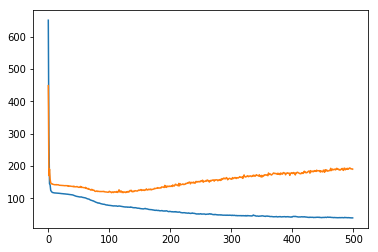

In [31]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

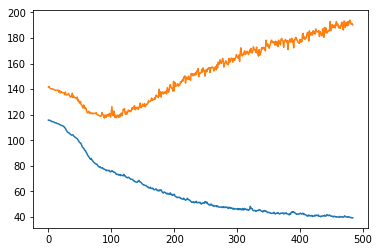

In [32]:
start = 15
plt.plot(history['loss'][start:])
plt.plot(history['val_loss'][start:])

In [33]:
name = 'hi_res-copy' + '-w-vae.h5'
# vae.load_weights(config.model_dir + name)

In [34]:
x.shape

(250, 160, 7, 1)

m (50, 7, 1)


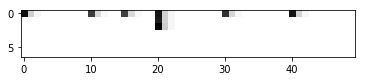

m (50, 7, 1)


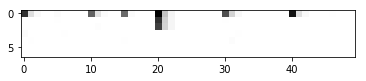

m (50, 7, 1)


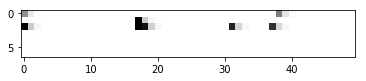

m (50, 7, 1)


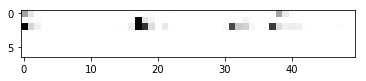

In [35]:
i = 240
j = 30
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [36]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [37]:
x.shape

(250, 160, 7, 1)

m (30, 7)


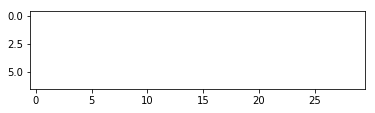

In [38]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 7)


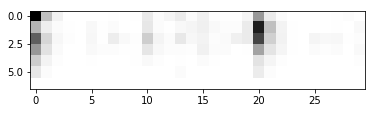

In [39]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Decoder (generator)
A model to project inputs on the latent space

In [40]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [41]:
generator_input = Input((latent_dim,))
generator_layers_ = utils.composition(decoders, generator_input)
generator = Model(generator_input, generator_layers_)

In [42]:
decoder = generator

# Save models to disk
(requires h5py)

In [43]:
encoder.to_json()

'{"class_name": "Model", "config": {"name": "model_2", "layers": [{"name": "input_1", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 160, 7, 1], "dtype": "float32", "sparse": false, "name": "input_1"}, "inbound_nodes": []}, {"name": "reshape_1", "class_name": "Reshape", "config": {"name": "reshape_1", "trainable": true, "target_shape": [160, 7]}, "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"name": "conv1d_1", "class_name": "Conv1D", "config": {"name": "conv1d_1", "trainable": true, "filters": 64, "kernel_size": [2], "strides": [1], "padding": "valid", "dilation_rate": [1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[

In [44]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1536      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
lambda_4 (Lambda)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 256)           0         
__________

In [45]:
from keras.models import model_from_json
from keras.models import model_from_yaml

In [46]:
inputs = Input((2,))
x = [Dense(3)]
x2 = [Dense(3)]
extra_d = Lambda(lambda layer: utils.composition(x2, layer))
x += [extra_d]
x = utils.composition(x, inputs)
model = Model(inputs, x)

In [47]:
import functools
foldl = lambda func, acc, xs: functools.reduce(func, xs, acc)

In [48]:
foldl(lambda f,g: f+g, 0, [0,1,2])

3

In [49]:
f1 = lambda v,f: f(v)
foldl(f1, 0, [lambda x: x+2] )

2

In [50]:
# arg = 3
# def make_model():
#     inputs = Input((2,))
#     x = [Dense(3)]
#     layers = [Dense(3)]
# #     extra_d = Lambda(lambda layer: utils.composition(layers, layer))
# #     extra_d = Lambda(lambda layer, x2: utils.composition(x2, layer), arguments={'x2':layers} )
# #     extra_d = Lambda(lambda layer, ar: Dense(arg)(layer), arguments={'ar': arg} )
#     f = lambda value, fun: fun(value)
# #     f = lambda fun, value: fun(value)
#     extra_d = Lambda(lambda layer: K.foldl(f, [Dense(3)], initializer=layer) )
#     extra_d = Lambda(lambda layer: K.foldl(f, [layer, Dense(3)]) )
# #     extra_d = Lambda(lambda x: Dense(3)(x))
# #     extra_d(Dense(3))
# #     print(extra_d, K.shape(extra_d))
#     x += [extra_d]
#     x = utils.composition(x, inputs)
#     model = Model(inputs, x)
#     return model
# model = make_model()

In [51]:
# model.to_json()

In [52]:
decoder.compile('adam','mse')

In [58]:
# decoder.to_json()

In [59]:
# decoder.to_yaml()

In [63]:
prefix = 'hi_res-copy-vae'
dn = config.model_dir
for pre, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
    model.save_weights(dn + prefix + '.h5', "w")

In [57]:
# models_io.save_model(vae, dn + prefix + '_vae')
# models_io.save_model(encoder, dn + prefix + '_encoder')
# models_io.save_model(generators, dn + prefix + '_generator')

In [64]:
x_test.shape

(50, 160, 7, 1)

In [65]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 5)

original
m (160, 7, 1)


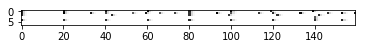

(6, 160, 7, 1) [ 1.2197999   0.31445315 -0.09596303 -1.1164614   0.32723543]
identity
m (160, 7, 1)


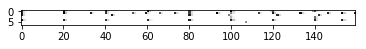

mutations
m (160, 7, 1)


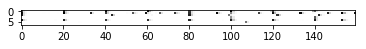

m (160, 7, 1)


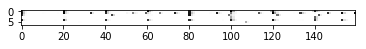

m (160, 7, 1)


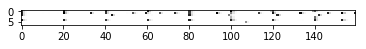

m (160, 7, 1)


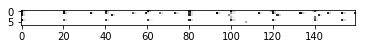

In [66]:
i = 100
amt = 0.3
print('original')
plot.single(x_train[i])
z = encoder.predict(x_train[i:i+1])
zs = [ z[0].copy() for _ in range(latent_dim) ]
for i,z_ in enumerate(zs):
    z_[i] = z_[i] + amt
generated = decoder.predict(np.concatenate([z[:1], zs]))
print(generated.shape, z[0,:5])
print('identity')
plot.single(generated[0]) 
print('mutations')
plot.single(generated[1])
plot.single(generated[2])
plot.single(generated[3])
plot.single(generated[4])

In [67]:
# utils.clear_dir(config.export_dir)
for i, sample in enumerate(generated):
    s = midi.MultiTrack.from_array(sample)
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'generated-' + str(i))

 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0


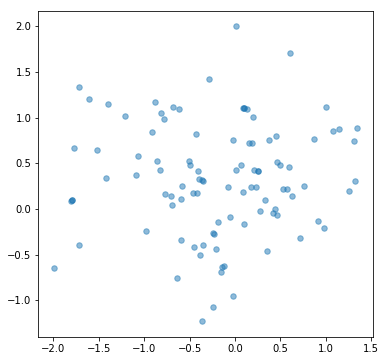

In [68]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.5, s=30) # c=y_test, 

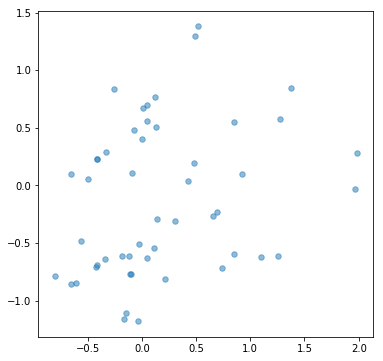

In [69]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.5, s=30) # , c=y_test
# plt.colorbar()

In [70]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [71]:
# x_decoded[0].reshape(150,3)

In [72]:
x_train.shape

(450, 160, 7, 1)

(5,) [0.5 0.5 0.5 0.5 0.5]


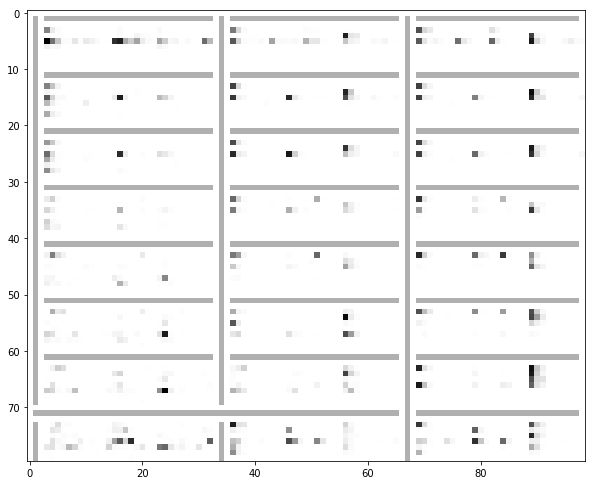

In [73]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(5,) [0.5 0.5 0.5 0.5 0.5]


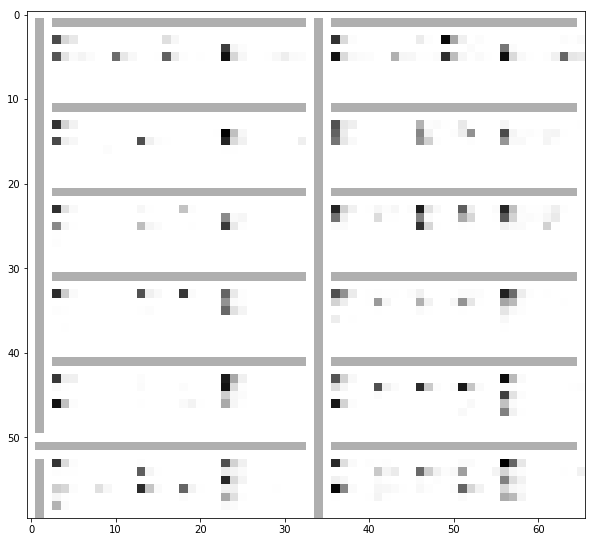

In [74]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,            
       n=6,
       m=2,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)

In [75]:
a = [0,11,100,399]
# utils.clear_dir(config.export_dir)
for i in a:
    s = midi.MultiTrack.from_array(x_train[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_true_' + str(i))
    
    s = midi.MultiTrack.from_array(y[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_pred' + str(i))    

 [INFO] : 
 |  len, max_t
 |  3.780208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.780208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [DEBUG] > 
 |>  old current
 |>  0.37500000000000006
 |>  0.3750000000000001
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.8802083333333335
 |  4.0


# Style transfer
rock ~ funk

In [76]:
[(a,b) for a,b in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/05 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/03 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/04 8th Perc.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/06 8th Perc.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/02 8th Hat.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/07 8th Perc.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/01 8th Hat.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/05 Straight Line 136BPM/06 8th hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/05 Straight Line 136BPM/02 8th Ride.mid"),
 (9,
  "../datasets/dr

../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/07 Thwag 170BPM/03 8th Hat.mid ../datasets/drum_midi//50´s Drummer MIDI Files/02 Blues/02 Nappy Brown 160BPM/05 8th Cym.mid ../datasets/drum_midi//50´s Drummer MIDI Files/05 Jazz/07 Kooper 234BPM/03 8th Hat.mid
m (80, 7, 1)


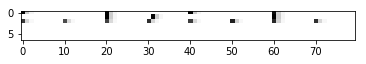

m (80, 7, 1)


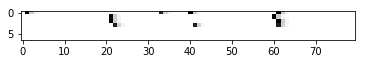

m (80, 7, 1)


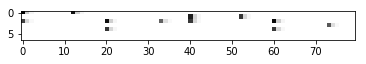

In [143]:
i,j, k = 21, 140, 105 # 210, 79
m = 80
sample_size = 10
print(labels[i], labels[j], labels[k])
plot.single(x_train[i,:m])
plot.single(x_train[j,:m])
plot.single(x_train[k,:m])

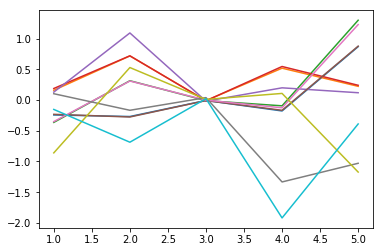

In [144]:
latent_vectors = encoder.predict(x_train[:250])
indices = np.arange(latent_vectors.shape[-1]) + 1
for l in range(sample_size):
    plt.plot(indices, latent_vectors[l + i])
# plt.ylim((-1,1))

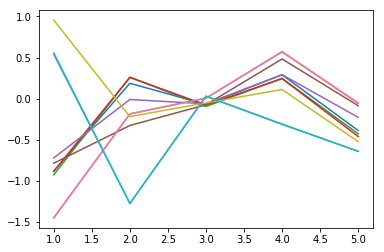

In [145]:
for l in range(sample_size):
    plt.plot(indices, latent_vectors[l + j])
# plt.ylim((-1,1))

In [148]:
a = x_train[i:i+sample_size]
b = x_train[j:j+sample_size]
c = x_train[k:k+sample_size]

In [152]:
def extract_transformation(encoder, stylesA, stylesB) -> np.array:
    # extract the linear latent transformation that corresponds with A -> B
    latent_vectors_A = encoder.predict(stylesA)
    latent_vectors_B = encoder.predict(stylesB)
    return latent_vectors_B.mean(axis=0) - latent_vectors_A.mean(axis=0)

def transfer_style(encoder, decoder, stylesA, stylesB, samples, amt=1.):
    # stylesA, stylesB, samples = lists of samples that can be encoded by `encoder`
    # encoder output must be a np array
    transformation = extract_transformation(encoder, stylesA, stylesB)
    latent_vectors = encoder.predict(samples)
    latent_vectors_ = apply_transformation(latent_vectors, transformation, amt)
    return decoder.predict(latent_vectors_)

def apply_transformation(vectors: np.array, transformation: np.array,
                         amt=1.) -> np.array:
    # np automatically maps the transformation to every instance with (+)
    return vectors + transformation * amt

In [153]:
t = extract_transformation(encoder, a, b)
t

array([-0.3404174 , -0.50374997, -0.03489671,  0.46469125, -0.57438886],
      dtype=float32)

m (80, 7, 1)


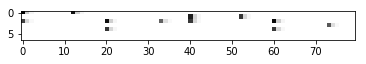

m (80, 7, 1)


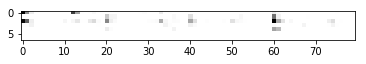

In [158]:
c_ = transfer_style(encoder, generator, a, b, c)
plot.single(c[0,:m])
plot.single(c_[0,:m])

In [169]:
d = {'original':c, 'generated':c_, 'a':a, 'b':b}
for k,v in d.items():
    mid = midi.decode.track(context, v[0])
    mid.tracks[0].name = k    
    io.export_midifile(mid, config.export_dir + 'style_transfer-' + k)

 [INFO] : 
 |  len, max_t
 |  3.855208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.8552083333333336
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.8802083333333326
 |  4.0
